In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

path = '../GKX/'
### Data preparation
## Load 94 firm characteristics dataset
data_ch = pd.read_csv(path+'GKX_20201231.csv')
data_ch['DATE'] = pd.to_datetime(data_ch['DATE'], format='%Y%m%d') + pd.offsets.MonthEnd(0)
data_ch = data_ch[(data_ch['DATE'] >= '1957-01-31') & (data_ch['DATE'] <= '2016-12-31')]
cols = data_ch.columns.tolist()
cols_new = [x for x in cols if x not in ['permno', 'prc', 'SHROUT', 'mve0']]
data_ch = data_ch[cols_new]

# Construct dummy variables
# Remove the samples with missing 'sic2'
data_ch  = data_ch.dropna(subset=['sic2']).reset_index(drop=True)
dummies = pd.get_dummies(data_ch['sic2'], prefix='dum_')
data_ch = data_ch.drop('sic2', axis=1)
data_ch = pd.concat([data_ch, dummies], axis=1)

# Replace all missings of firm characteristics with 0
chas = [x for x in cols_new if x not in ['DATE', 'RET', 'sic2']]
data_ch[chas] = data_ch[chas].fillna(0)

## Load 8 macroeconomic predictors
data_ma = pd.read_csv(path+'PredictorData2023.csv')
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'], format='%Y%m') + pd.offsets.MonthEnd(0)
data_ma = data_ma[(data_ma['yyyymm'] >= '1957-01-31') & (data_ma['yyyymm'] <= '2016-12-31')].reset_index(drop=True)
#data_ma

# Construct 8 macroeconomic predictors
ma_predictors = ['dp', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'svar']
data_ma['Index'] = data_ma['Index'].str.replace(',', '').astype('float64')
data_ma['dp'] = np.log(data_ma['D12'] / data_ma['Index'])
data_ma['ep'] = np.log(data_ma['E12'] / data_ma['Index'])
data_ma.rename(columns={'b/m': 'bm'}, inplace=True)
data_ma['tms'] = data_ma['lty'] - data_ma['tbl']
data_ma['dfy'] = data_ma['BAA'] - data_ma['AAA']
data_ma = data_ma[['yyyymm'] + ma_predictors]

# # Construct the dataset including all covariates
# data_ma_long = pd.merge(data_ch['DATE'], data_ma, left_on='DATE', right_on='yyyymm', how='left').drop('yyyymm', axis=1)
# for cha in chas:
#     for predictor in ma_predictors:
#         name = cha + '_' + predictor
#         data_ch[name] = data_ch[cha] * data_ma_long[predictor]
# data = data_ch

# concate without covariates
data = pd.merge(data_ch, data_ma, left_on='DATE', right_on='yyyymm', how='left').drop('yyyymm', axis=1)

## Split the dataset
def get_data_split(str, end):
    # covariates = list(set(data.columns).difference({'DATE','RET'}))
    # X = data[(data['DATE'] >= str) & (data['DATE'] <= end)][covariates].values
    ch = list(set(data.columns).difference({'DATE','RET'}))
    X = data[(data['DATE'] >= str) & (data['DATE'] <= end)][ch].to_numpy()
    y = data[(data['DATE'] >= str) & (data['DATE'] <= end)]['RET'].to_numpy()
    return X, y

def r2_score(y, yhat):
    r2 = 1 - sum((y - yhat) ** 2) / sum(y ** 2)
    return r2

In [3]:
init_train_str = '1957-01-31'; init_train_end = '1974-12-31'
init_val_str = '1975-01-31'; init_val_end = '1986-12-31'
init_test_str = '1987-01-31'; init_test_end = '2016-12-31'
year_span = 30
### Model Fit
enet_oos_r2 = []
enet_oos_para = []
for i in range(year_span):
    # Get training dataset, test dataset split, test for one year
    str = pd.to_datetime(init_train_str)
    end = pd.to_datetime(init_val_end)+pd.DateOffset(years=i)
    oos_str = end + pd.DateOffset(years=1)
    oos_end = oos_str
    
    x_train, y_train = get_data_split(str, end)
    x_test, y_test = get_data_split(oos_str, oos_end)

    # Fit model
    #alpha=1,0.1,0.01, l1_ratio=0.5,0.3,0.1
    enet = ElasticNet(alpha=0.01,l1_ratio=0.3) 
    enet_model = make_pipeline(StandardScaler(), enet)
    enet_model.fit(x_train, y_train)

    # test
    y_test_hat = enet_model.predict(x_test).flatten()
    oos_r2= r2_score(y_test,y_test_hat)
    enet_oos_r2.append(oos_r2)
    
    # record
    # total_para - zero_para
    eff_para = enet.coef_.shape[0] - np.where(enet.coef_==0)[0].shape[0]
    enet_oos_para.append(eff_para)
    print("year:{0}/30, r^2:{1}, para:{2}".format(i+1,oos_r2,eff_para))

year:1/30, r^2:0.005128881072784308, para:8
year:2/30, r^2:0.013976888617776684, para:8
year:3/30, r^2:-0.008483129174205573, para:7
year:4/30, r^2:-0.021236399709036347, para:7
year:5/30, r^2:0.01962548154702337, para:7
year:6/30, r^2:0.03144716211024934, para:8
year:7/30, r^2:0.00943609815069446, para:8
year:8/30, r^2:-0.005700440517024674, para:7
year:9/30, r^2:0.0014343237943691411, para:9
year:10/30, r^2:-0.006176204595162771, para:9
year:11/30, r^2:-0.005910066030531569, para:9
year:12/30, r^2:0.005117503998643191, para:10
year:13/30, r^2:0.009797480302644157, para:9
year:14/30, r^2:-0.005495446004204929, para:9
year:15/30, r^2:0.06047660707372238, para:7
year:16/30, r^2:-0.10827927793283654, para:8
year:17/30, r^2:0.056077363779694966, para:9
year:18/30, r^2:0.07277884359719766, para:8
year:19/30, r^2:0.0055731413270180274, para:8
year:20/30, r^2:0.016718956833412846, para:9
year:21/30, r^2:-0.050868742126900734, para:8
year:22/30, r^2:-0.010153272261590685, para:8
year:23/30, r

In [ ]:
enet_rec = pd.DataFrame({'r^2':enet_oos_r2,'r^2':enet_oos_r2,'eff_para':enet_oos_para})
enet_rec.to_csv("enet.csv",index=False,sep=',')

### Plot the Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
enetdata = pd.read_csv("./enet.csv")

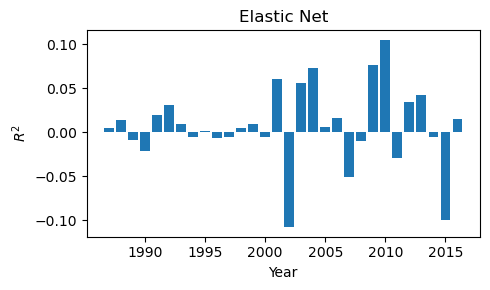

In [2]:
plt.figure(figsize=(5,3))
plt.title("Elastic Net")
plt.xlabel('Year')
plt.ylabel('$R^2$')
plt.bar(np.arange(1987,2017),enetdata['r^2'])
plt.tight_layout()

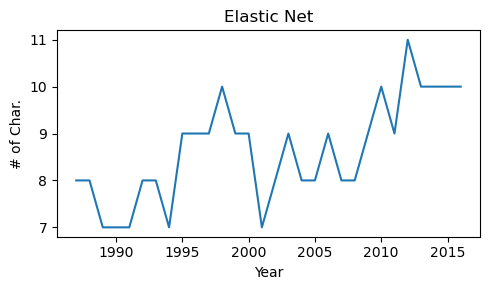

In [3]:
plt.figure(figsize=(5,3))
plt.title("Elastic Net")
plt.xlabel('Year')
plt.ylabel('# of Char.')
plt.plot(np.arange(1987,2017),enetdata['eff_para'])
plt.tight_layout()

In [9]:
r2_total = sum(enetdata['r^2'])-max(enetdata['r^2'])-min(enetdata['r^2'])
r2 = r2_total/(enetdata['r^2'].shape[0]-2)
print("avg R2: {0:.4f}".format(r2))

avg R2: 0.0081
